# Classification of CubeSat Data using CNN  - Team 3

#### Brazil Data Science Regional Hackathon

Team Members: Gabriel Christino, Marcela Gouvêa, Matheus Poltronieri

**In this notebook, we use MobileNetV2 as a base model for our CNN Model in order to classify data captured by CubeSat and prioritize images that are most valuable to transmission back to Earth**

---

### Import packages and load data

In [ ]:
import gc
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense,BatchNormalization, Activation
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical

2025-03-20 17:08:44.949288: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 17:08:44.956756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 17:08:44.972969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 17:08:44.995018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 17:08:45.001251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 17:08:45.024264: I tensorflow/core/platform/cpu_feature_gu

Load training and validation data

In [ ]:
train_images = np.load('data/train_images.npy')  # Load image training data
train_labels = np.load('data/train_labels.npy')  # Load label training data

val_images = np.load('data/val_images.npy')  # Load image training data
val_labels = np.load('data/val_labels.npy')  # Load image training data

print("Data loaded successfully from NumPy files.")

Data loaded successfully from NumPy files.


Check data shape

In [ ]:
print(train_images.shape,train_labels.shape)
print(val_images.shape,val_labels.shape)

(9711, 512, 512, 3) (9711,)
(3237, 512, 512, 3) (3237,)


---

### Preprocessing

We chose to reduce image size from (512, 512) to (256, 256)

In [ ]:
def preprocess(image):
    image = tf.image.resize(image, (224, 224))   # Resize
    image = (image / 127.5) - 1  # Normalize from [0, 255] to [-1, 1]
    return image

train_images = preprocess(train_images)
val_images = preprocess(val_images)

2025-03-20 17:09:18.742119: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7637041152 exceeds 10% of free system memory.
2025-03-20 17:09:25.614053: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5847109632 exceeds 10% of free system memory.
2025-03-20 17:09:32.934039: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5847109632 exceeds 10% of free system memory.
2025-03-20 17:09:33.358700: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5847109632 exceeds 10% of free system memory.


In [ ]:
# shape after preprocessing
print(train_images.shape,val_images.shape)

(9711, 224, 224, 3) (3237, 224, 224, 3)


In [ ]:
# max and min values after preprocessing
min_value_train = tf.reduce_min(train_images)
max_value_train = tf.reduce_max(train_images)

print("Valor mínimo train:", min_value_train.numpy())
print("Valor máximo train:", max_value_train.numpy())

min_value_val = tf.reduce_min(val_images)
max_value_val = tf.reduce_max(val_images)

print("Valor mínimo val:", min_value_train.numpy())
print("Valor máximo val:", max_value_train.numpy())

Valor mínimo train: -1.0
Valor máximo train: 1.0
Valor mínimo val: -1.0
Valor máximo val: 1.0


---

### Train CNN model

One-hot encode the labels

In [ ]:
train_labels = to_categorical(train_labels, num_classes=5)
val_labels = to_categorical(val_labels, num_classes=5)
print(train_labels.shape,val_labels.shape)

(9711, 5) (3237, 5)


**We then download the pre-trained model MobileNetV2. This model is trained on another dataset and it is used as the base for our CNN (Transfer Learning). We then train our model adding the global average pooling layer and an output layer with 5 neurons and softmax activation**

- MobileNetV2 is a convolutional neural network architecture that seeks to perform well on mobile devices.
- The architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers.

In [ ]:
# Pretrained model
base_model = MobileNetV2(weights='imagenet', include_top=False, alpha = 0.35, input_shape=(224,224,3))

base_model.trainable = False

# Define the CNN model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Global average pooling layer
    Dense(5, activation='softmax')  # Output layer with 5 neurons (one for each class) + Softmax activation
])

# Compile the model with appropriate loss function, optimizer, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Model defined and compiled successfully.")

# Train the model on the training data
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images,val_labels),
    epochs=10,  # Number of epochs
    batch_size=32,  # Batch size
)

print("Model training complete.")

Model defined and compiled successfully.
Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - accuracy: 0.8421 - loss: 0.4873 - val_accuracy: 0.9981 - val_loss: 0.0255
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.9982 - loss: 0.0188 - val_accuracy: 0.9991 - val_loss: 0.0110
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.9995 - loss: 0.0085 - val_accuracy: 0.9991 - val_loss: 0.0068
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.9999 - loss: 0.0058 - val_accuracy: 0.9994 - val_loss: 0.0045
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.9999 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.9999 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 39s 128ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 39

Check accuracy/loss vs epochs plots for training and validation

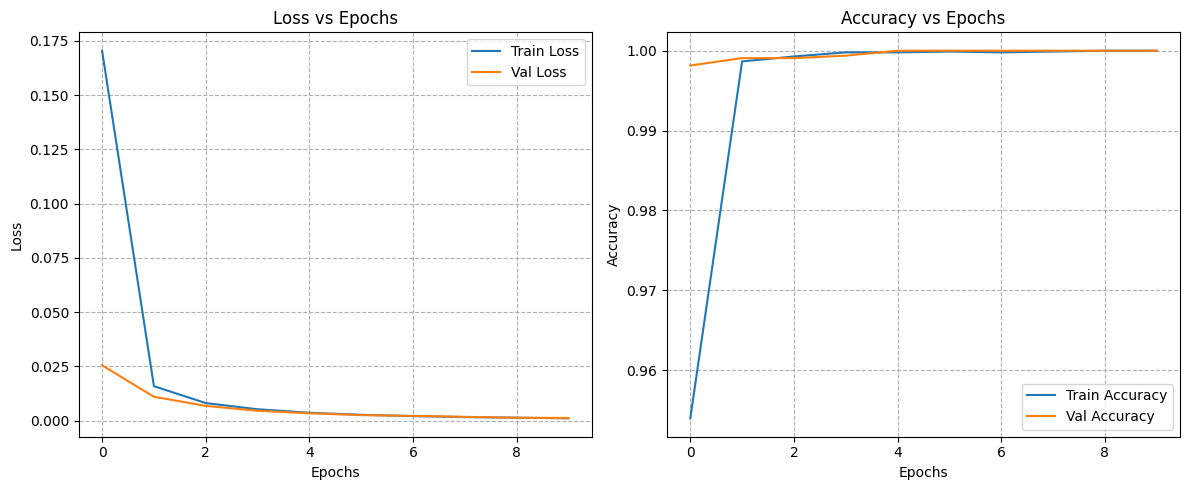

In [ ]:
#Plotting Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(ls='--')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(ls='--')
plt.legend()

plt.tight_layout()
#plt.savefig('batch_loss_accuracy_renorm_mobileV2net_1.0_224_224_alpha0.35.png')
plt.show()

##### **Saving the CNN model**

In [ ]:
with open('renorm_mobilev2net_batch_32_1.0_224_224_alpha0.35.pkl', 'wb') as file:
    pickle.dump(model, file)

---

### Deep learning: Validation set results

In [ ]:
with open('renorm_mobilev2net_batch_32_1.0_224_224_alpha0.35.pkl', 'rb') as file:
    cnn_loaded_model = pickle.load(file)

val_predictions = cnn_loaded_model.predict(val_images)

102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step


In [ ]:
val_predictions = np.argmax(val_predictions, axis=1)
val_labels = np.argmax(val_labels, axis=1)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       1.00      1.00      1.00       222
           2       1.00      1.00      1.00       421
           3       1.00      1.00      1.00       721
           4       1.00      1.00      1.00      1146

    accuracy                           1.00      3237
   macro avg       1.00      1.00      1.00      3237
weighted avg       1.00      1.00      1.00      3237



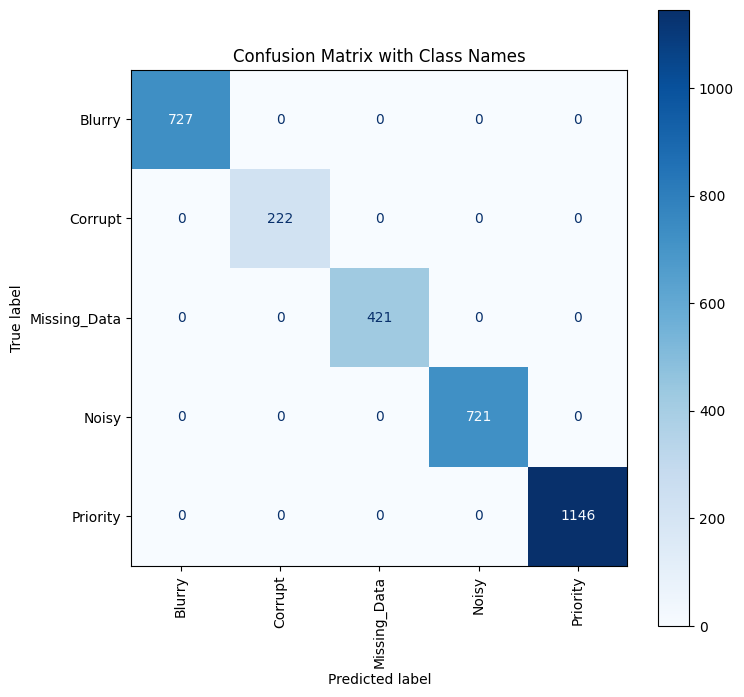

In [ ]:
# Define class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Customize and display the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Set the figure size
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')  # Use a blue colormap
plt.title("Confusion Matrix with Class Names")
#plt.savefig('confusion_matrix_renorm_batch_32_1.0_224_224_alpha0.35.png')
plt.show()

In [ ]:
# Remove the data from memory
del train_images, train_labels, val_images, val_labels, val_predictions

# Force garbage collection to free up memory
gc.collect()

print("Data and models removed from memory.")

Data and models removed from memory.


---

### Evaluate Pipeline

First let us load the testing data

In [ ]:
test_images = np.load('data/test_images.npy')      # Load image test data
test_labels = np.load('data/test_labels.npy')      # Load label test data

Import Evaluation function

In [ ]:
from source.evaluate import evaluate_pipeline # A built-in function to evaluate a given ML pipeline by preprocessing, predicting, and calculating performance metrics.

Define preprocessing function

In [ ]:
def preprocessing_fn_CNN(X):
    X = tf.image.resize(X, (224, 224)) # reduce image quality
    X = (X / 127.5) - 1  # Normalize from [0, 255] to [-1, 1]
    return X

Load the CNN model

In [ ]:
test_labels = to_categorical(test_labels, num_classes=5)

with open('renorm_mobilev2net_batch_32_1.0_224_224_alpha0.35.pkl', 'rb') as file:
    cnn_model = pickle.load(file)

Evaluate the pipeline

102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step

### Evaluation Metrics ###

Evaluation Time:       27.86 seconds (The time it took for the pipeline to preprocess data and make predictions.)
Peak Memory Usage:     10943.29 MB (The maximum memory used during evaluation.)
Average CPU Usage:     376.81 % (The % shows how much of one CPU core was used during the evaluation.)
Algorithm code size:         2.17 MB (The size of the trained model and preprocessing function.)
Accuracy:              1.000 (The percentage of correctly classified samples.)
F1 Score:              1.000 (A balance of precision and recall, useful for imbalanced datasets.)

### Confusion Matrix ###



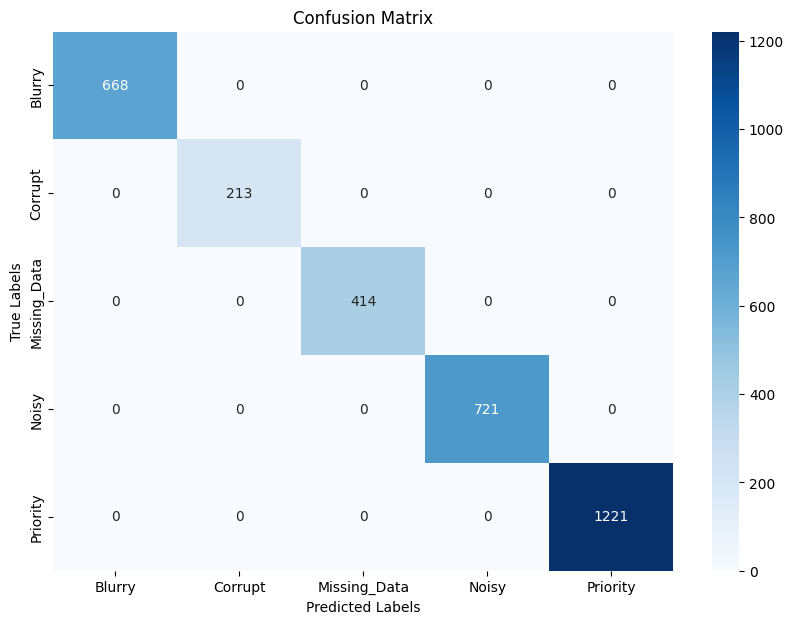

In [ ]:
metrics = evaluate_pipeline(cnn_model, test_images, test_labels, preprocessing_fn_CNN)

##### **⚠️ Freeing up Space**

In [ ]:
# Remove the data from memory
del cnn_model, test_images, test_labels

# Force garbage collection to free up memory
gc.collect()

print("Data and models removed from memory.")

Data and models removed from memory.
